# PyTorch Workflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.0'

## 1. Data (preparing and loading)

1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representations.

Linear Regression with known **parameters**

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
squeezed_X = torch.arange(start, end, step)
unsqueezed_X = squeezed_X.unsqueeze(dim=1) # add extra dim
y = weight * unsqueezed_X + bias

In [4]:
len(unsqueezed_X), len(y)

(50, 50)

### Splitting data

- **GOAL:** Generalization [to perform well on data it hasn't seen before]
    - Training set (ie: course materials)
    - Validation set (ie: practice exam)
    - Testing set (ie: final exam)

- There's a direct mapping of train input : test output

In [5]:
train_split_len = int(0.8 * len(unsqueezed_X))
train_split_len

40

In [6]:
X_train, y_train = unsqueezed_X[:train_split_len], y[:train_split_len]
len(X_train), len(y_train)

(40, 40)

In [7]:
X_test, y_test = unsqueezed_X[train_split_len:], y[train_split_len:]
len(X_test), len(y_test)

(10, 10)

How might we better visualize out data?

In [8]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """Plots training data, test data, and compares predictions"""

    plt.figure(figsize=(5, 5))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size": 14})

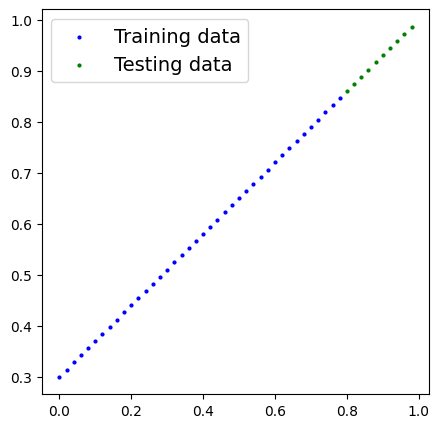

In [9]:
plot_predictions()

## 2. Build model

- Using OOP in Python. See Real Python: https://realpython.com/python3-object-oriented-programming/
- `Linear Regression Model`
    1. Goal is to draw the line that passes as close as possible to the points [1 | P 36]
    2. Mathematical representation [2 | P 19]
        $$
        y(x) = w^T \cdot x + \epsilon = \sum_{j=1}^D w_j \cdot x_j + \epsilon
        $$
        
        - $w$, weights
        - $\cdot$, matrix multiplication [3]
        - $x$, input vector
        - $\epsilon$, residual error or learnable bias parameter between our linear predictions and the true response
- Process:
    1. Start with random values for $w$ and $\epsilon$
    2. Look at training data and adjust random values to be what would represent the line, hence definition above.
        - How? Hence why `require_grad = True` to track the gradients with `torch.autograd`
            1. Gradient descent
                - [adjusts params to find best combination of params] 
                - Mathematical representation [2 | P 247]
                    $$ \theta_{k + 1} = \theta_k - \eta_kg_k$$
                - See [4] for a visualization
            2. Backpropagation [5]

In [29]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Randomly initializations our learnable model parameters
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

        # Forward method to define the computation in the model
    def forward(self, input_x: torch.Tensor) -> torch.Tensor:
        y = self.weights * input_x + self.bias
        return y


### Checking the contents of our PyTorch model

- Use `.parameters()`

In [42]:
# Create random seed because we initialize randomly and want to stablize our random values
# stablize as in keep random #s same; remove manual_seed() and model params will change
# helps with reproducing works
torch.manual_seed(42)

# Create instance of model (this is a subclass of of nn.Module)
linear_regression_model = LinearRegressionModel()

# Check out parameters
linear_regression_model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

- Want `self.weights` and `self.bias` to be close to the ideal `weights` and `bias` set above

In [31]:
weight, bias

(0.7, 0.3)

### Making predictions usings `torch.inference_mode()`

- See how well model predicts `y_test` based on `X_test`
- Pass data through model via `forward()` method
- `torch.inference_mode()` 
    - Removes gradient tracking
    - When doing inference, we're NOT training, so don't need to keep track of gradients/ how to update model
    - Benefit is that it makes code run faster as we're NOT saving gradients

In [32]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [44]:
# Make predictions with model
with torch.inference_mode():
    lr_y_preds = linear_regression_model.forward(X_test)

# Similar as above, however inference_mode is preferred
# with torch.no_grad():
#     lr_y_preds = linear_regression_model.forward(X_test)

lr_y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

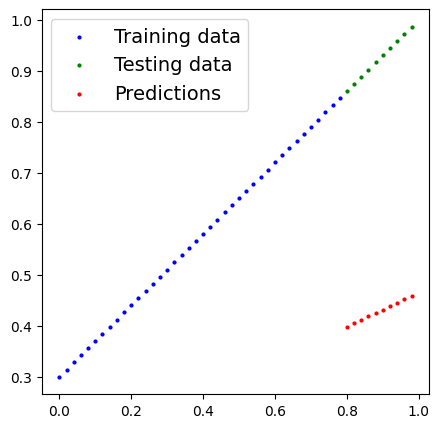

In [45]:
plot_predictions(predictions=lr_y_preds)

## 3. Train model

- Move from unknown params to known params or from a poor representation of data to better representation
    - How?
        1. **Loss function:** Calculates how poor or how wrong our model's output vs the true output
        2. **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters ($w$, $\epsilon$) accordingly to improve the loss function
        3. **Training loop:**
        4. **Testing loop:**

- Loss function is also called **criterion** and **cost function**
    - Another way other than `nn.L1Loss()` is `torch.mean(torch.abs(y_pred, y_test))`
- Learning rate is `lr` [how quickly to adjust the model's parameters
    - A hyperparameter [something we set]
    - Small `lr` $\rightarrow$ small params change
    - Large `lr` $\rightarrow$ large params change

In [ ]:
# Setup a loss function - How wrong out model is
loss_fn = nn.L1Loss()

# Setup the SGD optimizer
# Stochastic [random] gradient descent [adjusts parameters]
# Communicates with the loss function by saying
# when I randomly adjust these parameters, do we tend in the direction we want?
# if so, keep adjusting in this direction and 
# if no, adjust in the other/another direction
optimizer = torch.optim.SGD(params=linear_regression_model.parameters(), lr=0.01) 

### Building a training and testing loop in PyTorch

- Requirements:
    0. Loop through the data
    1. Forward pass with `forward()` function
    2. Loss
    3. Optimize

# References

1. BOOK: Grokking ML by Luis G. Serrano
2. BOOK: Machine Learning a Probabilistic Perpective by Kevin Murphy
3. CODE: [Matrix Arithmetic](https://github.com/Brinkley97/lin_alg_for_ml_jason_brownlee/tree/main/part_iv_matrices/9-matricies_matrix_arithmetic) by Detravious Jamari Brinkley
4. VIDEO: [Gradient descent, how neural networks learn | Chapter 2, Deep learning](https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3) by 3Blue1Brown
5. VIDEO: [What is backpropagation really doing? | Chapter 3, Deep learning](https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3) by 3Blue1Brown